## Find optimal anchor boxes for YOLOv2

Extracts the widths and heights of all bounding boxes in the COCO- and PascalVOC training datasets and runs k-means clustering with a IoU distance to find the optimal anchor boxes.

These anchor boxes are then saved as dictionaries in the json files `anchor_boxes_coco.json` and `anchor_boxes_pascalvox.json` for further use.

In [1]:
import glob
import xml.etree.ElementTree as ET
import matplotlib as mpl
from matplotlib import pyplot as plt
import json
from pycocotools.coco import COCO
from anchor_boxes import *
%matplotlib inline

loading annotations into memory...
Done (t=10.85s)
creating index...
index created!
======== coco ========
Number of bounding boxes:  860001
Lloyds algorithm converged in 137 iterations
*** Anchor boxes*** 
0 :  0.69 x  0.75
1 :  0.04 x  0.06
2 :  0.49 x  0.29
3 :  0.13 x  0.18
4 :  0.22 x  0.50
======== pascalvoc ========
Number of bounding boxes:  40138
Lloyds algorithm converged in 34 iterations
*** Anchor boxes*** 
0 :  0.20 x  0.35
1 :  0.61 x  0.41
2 :  0.78 x  0.83
3 :  0.08 x  0.13
4 :  0.34 x  0.69


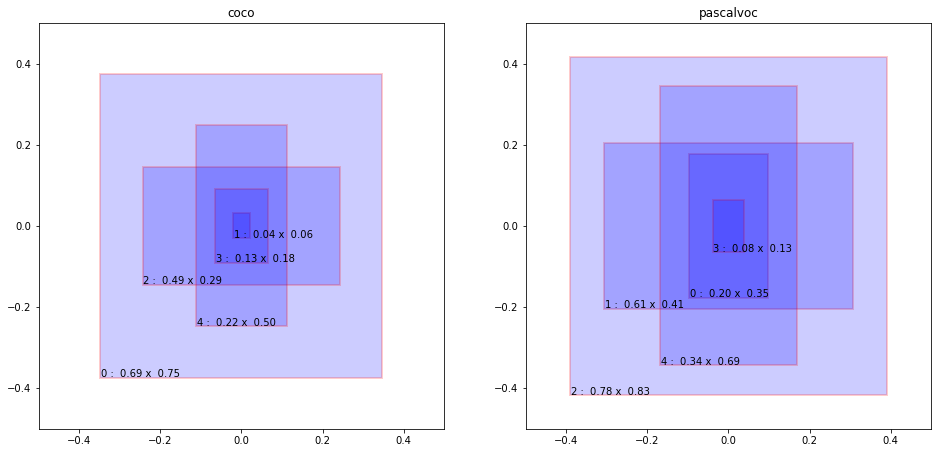

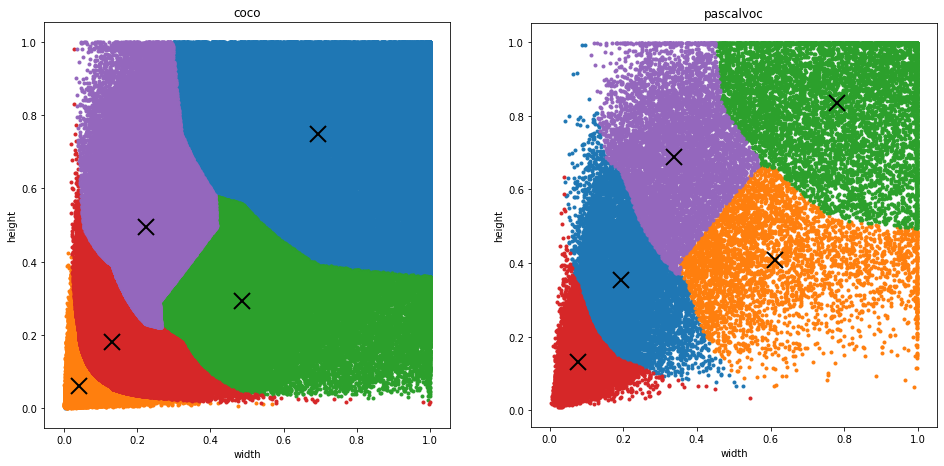

In [16]:
def load_bbox_wh_coco(data_dir="../../cocodata/",data_type = "train2017"):
    """Create an a list of all anchor box widths and heights for the COCO dataset

    The returned list contains tuples of the form (width, height), where both
    width and height are measured in units of the image size.
    
    :arg data_dir: directory containing the COCO data
    :arg data_type: type of data, e.g. train2017
    """
    ann_file=f"{data_dir}/annotations/instances_{data_type}.json"
    coco = COCO(ann_file)
    cat_ids = coco.getCatIds(catNms=['any'])
    img_ids = coco.getImgIds(catIds=cat_ids)
    bbox_wh = []
    for img_id in img_ids:
        img_info = coco.loadImgs([img_id])[0]
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        for ann_id in ann_ids:
            annotation = coco.loadAnns([ann_id])
            bbox_wh.append([annotation[0]['bbox'][2]/img_info['width'],
                            annotation[0]['bbox'][3]/img_info['height']])
        
    return np.asarray(bbox_wh)

def load_bbox_wh_pascalvoc(data_dir="../../pascalvocdata/VOC2012/"):
    """Create an a list of all anchor box widths and heights for the PascalVOC dataset

    The returned list contains tuples of the form (width, height), where both
    width and height are measured in units of the image size.
    
    :arg data_dir: directory containing the PascalVOC data. The .xml files with
                   annotations are expected to be stored in the subdirectory
                   "Annotations/" of this directory
    """
    annotation_dir = data_dir + "/Annotations/"
    annotation_filenames = glob.glob(annotation_dir + "/*.xml")
    bbox_wh = []
    for filename in annotation_filenames:
        tree = ET.parse(filename)
        root = tree.getroot()
        image_size = {}
        for node_size_spec in root.find("size"):
            image_size[node_size_spec.tag] = int(node_size_spec.text)
        # extract raw bounding boxes
        for node_object in root.iter("object"):
            bbox = {}
            for node_bbox in node_object.find("bndbox"):
                bbox[node_bbox.tag] = int(float(node_bbox.text))
            bbox_wh.append( [ (bbox["xmax"]-bbox["xmin"]) / image_size["width"],
                              (bbox["ymax"]-bbox["ymin"]) / image_size["height"] ] )
    return np.asarray(bbox_wh)

def visualise_anchor_boxes(anchor_boxes, ax):
    """Print out anchor boxes and plot them
    
    :arg anchor_boxes: list with tuples of form (width, height) for all anchor boxes    
    :arg ax: matplotlib axis object to plot to
    """
    print ("*** Anchor boxes*** ")
    for j,anchor_box in enumerate(anchor_boxes):
        print (f"{j} : {anchor_box[0]:5.2f} x {anchor_box[1]:5.2f}")

    # visualise bounding boxes
    ax.set_xlim(-0.5,+0.5)
    ax.set_ylim(-0.5,+0.5)
    for j,anchor_box in enumerate(anchor_boxes):
        w,h = anchor_box[0], anchor_box[1]
        x,y = -0.5*w,-0.5*h
        ax.add_patch(mpl.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='red',facecolor='blue',alpha=0.2))
        ax.text(x+0.002,y+0.002,f"{j} : {w:5.2f} x {h:5.2f}")


def save_anchor_boxes(anchor_boxes, filename):
    """Save anchor boxes as a dictionary to json file
    
    :arg anchor_boxes: list consisting of tuples (width, height) for all anchor boxes
    :arg filename: name of json file to save dictionary to
    """
    # Save to json as a dictionary
    anchor_box_dict = []
    for anchor_box in anchor_boxes:
        anchor_box_dict.append({'width':anchor_box[0],'height':anchor_box[1]})
    with open(filename,'w',encoding='utf8') as f:
        json.dump(anchor_box_dict,f,indent=4)

##############################################################################################
#### M A I N #################################################################################
##############################################################################################


# number of anchor boxes (= number of centroids for k-means clustering)
n_anchors=5

bbox_wh = {'coco':load_bbox_wh_coco(data_dir="../../cocodata/",data_type = "train2017"),
           'pascalvoc':load_bbox_wh_pascalvoc(data_dir="../../pascalvocdata/VOC2012/")}

fig_anchors, ax_anchors = plt.subplots(1, 2,figsize=(16,8))
fig_cluster, ax_cluster = plt.subplots(1, 2,figsize=(16,8))

for j, dataset in enumerate(bbox_wh.keys()):
    print (f"======== {dataset} ========")

    print ("Number of bounding boxes: ",bbox_wh[dataset].shape[0])

    # k-means clustering using IoU distance
    kmeans = KMeans(distanceIoU,n_centroid=n_anchors)
    assignments, anchor_boxes = kmeans.cluster(bbox_wh[dataset],maxiter=200)
    
    # visualise anchor boxes
    ax = ax_anchors[j]
    ax.set_aspect(1.0)
    ax.set_title(dataset)
    visualise_anchor_boxes(anchor_boxes,ax)

    # visualise clustered data
    ax = ax_cluster[j]
    ax.set_aspect(1.0)
    ax.set_title(dataset)
    plot_kmeans_data(bbox_wh[dataset], assignments, anchor_boxes,ax,label_x='width',label_y='height')

    # save anchor boxes to json file
    save_anchor_boxes(anchor_boxes, f"anchor_boxes_{dataset}.json")